In [27]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer
from lightgbm import LGBMModel
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import json
import matplotlib.pyplot as plt
from customtransformers.custom_transformers import (catboost_enc,target_enc,inputer,column_select,
                                                    strip_strings,control_discrimination)

# Get the data from the searched cars

In [28]:
data = pd.read_csv("data/train.csv")
data = data[data.VehicleSearchedIndicator]

data['InterventionDateTime']= pd.to_datetime(data['InterventionDateTime'])
data_train = data[(data['InterventionDateTime']<'2018') ]
data_test = data[data['InterventionDateTime']>'2018']

X_train,y_train = data_train.drop('ContrabandIndicator',axis=1),data_train.ContrabandIndicator*1
X_test,y_test = data_test.drop('ContrabandIndicator',axis=1),data_test.ContrabandIndicator*1
data.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
71,True,False,Bridgeport,10/01/2013 12:46:00 AM,Bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
143,True,True,Milford,10/01/2013 01:50:00 AM,MILFORD,E,2325,True,I,Defective Lights,30.0,N,W,M,True
184,True,False,Torrington,10/01/2013 03:49:00 AM,Torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True
203,True,False,State Police,10/01/2013 05:30:00 AM,TOLLAND,V,1000002715,False,C,Other,19.0,N,B,M,False
212,True,False,Greenwich,10/01/2013 05:47:00 AM,RIVERSIDE,V,110993,False,N,Speed Related,34.0,M,B,M,False


# Create the pipeline

In [29]:
target_cols = ['SearchAuthorizationCode', 'InterventionLocationName']
cat_boos_cols =  ['Department Name','StatuteReason']

drop_cols = ['VehicleSearchedIndicator','ReportingOfficerIdentificationID','InterventionReasonCode',
       'SubjectRaceCode', 'SubjectEthnicityCode', 'SubjectSexCode',
       'ResidentIndicator','lng','TownResidentIndicator','density','county_fips','day_of_year','lat']
string_cols = ['InterventionLocationName']

preprocess = Pipeline(steps=[
    ('strip_string',strip_strings(string_cols)),
    ('inpute_states', inputer(columns = ['InterventionLocationName'],strategy='constant',value='NA')),
    ('target_enc', target_enc(columns = target_cols)),
    ('catboost_enc', catboost_enc(columns =cat_boos_cols)),
    ('inpute', inputer(columns = ['StatuteReason'])),
    ('select_columns',column_select(['SearchAuthorizationCode', 'Department Name',
       'InterventionLocationName', 'StatuteReason']))
])

# criando o modelo usando pipeline
model = Pipeline(steps=[
    ('preprocess',preprocess),
    ('tree', LGBMClassifier(n_jobs=-1,n_estimators=1000,importance_type='gain'))
])

# Train and Test the model

In [31]:
model.fit(X_train,y_train)
preds_test = model.predict_proba(X_test)[:,1]


C:\Users\Francisco\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Minimum k that guarantees 50% of success 0.393939393939394
k that maximizes contraband found is: 0.393939393939394
 
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8412
           1       0.60      0.70      0.65      4676

    accuracy                           0.73     13088
   macro avg       0.71      0.72      0.71     13088
weighted avg       0.74      0.73      0.73     13088



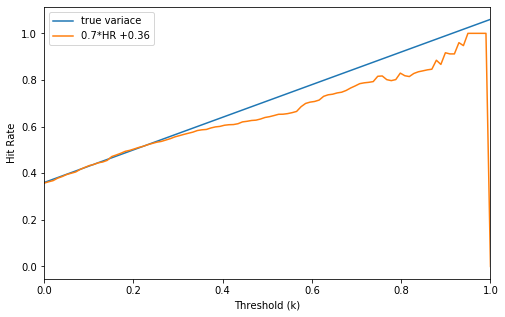

In [32]:
def get_threshold(preds,y_true,legend = False):
    precision_hist = []
    rec_hist = []
    for th in np.linspace(0,1,100):
        y_pred = (preds>th)*1
        precision_hist.append((th,classification_report(y_true, y_pred,output_dict=True)['1']['precision']))
        rec_hist.append((th,classification_report(y_true, y_pred,output_dict=True)['1']['recall']))

    k = np.array(precision_hist)[np.argmax(np.array(precision_hist)[:,1]>0.6)][0]
    print('Minimum k that guarantees 50% of success',k)
    if(rec_hist[np.argmax(np.array(rec_hist)[:,1])][0]>k):
        k = rec_hist[np.argmax(np.array(rec_hist)[:,1])][0]
    print('k that maximizes contraband found is:',k)
    y_pred = (preds>k)*1
    print(' ')
    print(classification_report(y_true, y_pred))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(np.array(precision_hist)[:,0],np.array(precision_hist)[:,0]*0.7 +0.36)#This weuation was found for the whole dataset
    pd.DataFrame(np.array(precision_hist)).plot(x=0,y=1,ax=ax,legend='0.4')
    ax.set_xlabel('Threshold (k)')
    ax.set_ylabel('Hit Rate')
    if(legend):
        ax.legend(['true variace','0.7*HR +0.36'])
    return k


k = get_threshold(preds_test,y_test,legend=True)

# Saving the model

In [33]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

import joblib
joblib.dump(model, 'modelv2.pickle') 

with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

# Train the model in the whole dataset

For all the analysis of the notebooks and the report, the previously trained model on the training set was used. However, in order to increase the quality of the model, the final model that was depoyed was the following one, trained on the whole dataset

In [23]:
model = Pipeline(steps=[
    ('preprocess',preprocess),
    ('tree', LGBMClassifier(n_jobs=-1,n_estimators=1000,importance_type='gain'))
])
model.fit(data.drop('ContrabandIndicator',axis=1),data.ContrabandIndicator*1)


Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('strip_string',
                                  strip_strings(columns=['InterventionLocationName'])),
                                 ('inpute_states',
                                  inputer(columns=['InterventionLocationName'],
                                          strategy='constant', value='NA')),
                                 ('target_enc',
                                  target_enc(columns=['SearchAuthorizationCode',
                                                      'InterventionLocationName'])),
                                 ('catboost_enc',
                                  catboost_e...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='gain',
                                learning_rate=0.1, max_depth=-1,
                                mi

In [24]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

import joblib
joblib.dump(model, 'modelv2.pickle') 

with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)